In [211]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizer
# import Adam optimizer
from torch.optim import AdamW
import torch.nn.functional as F

from gensim.models import Word2Vec, KeyedVectors
from torch import nn
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [212]:
TOP_N_WORDS = 50
SIZE_DATA = '3k'
VECTOR_SIZE = 50

In [213]:
df = pd.read_csv(f'./data/df_10_category_balance_{SIZE_DATA}_pca.csv')
X = df['text']
y = df['category']

### Get the Most Common Words

In [214]:
all_words = [w for text in X for w in text.split()]
all_words_freq = pd.Series(all_words).value_counts()
all_words_freq

new            3241
photo          2914
one            2763
year           2339
time           2335
               ... 
macallan          1
makeoverand       1
ysls              1
khichdi           1
latif             1
Length: 42187, dtype: int64

In [181]:
percentage_list = []
count = 0
total = len(all_words)
for i in range(1, total):
    count += all_words_freq[i]
    percentage_list.append(count/total)
    if percentage_list[-1] > 0.9:
        print(f'the {i} words {all_words_freq.index[i]} that make up 90% of the corpus, the freq is {all_words_freq[i]}')
        break

the 10494 words ct that make up 90% of the corpus, the freq is 6


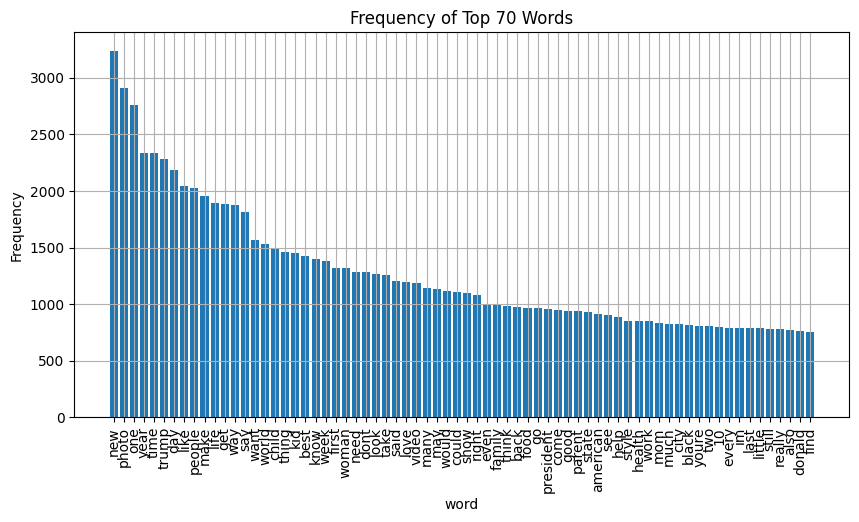

In [182]:
plt.figure(figsize=(10, 5))
plt.bar(all_words_freq.index[:70], all_words_freq.values[:70])
plt.xlabel('word')
plt.ylabel('Frequency')
plt.title('Frequency of Top 70 Words')
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [183]:
num = 60
print(f'Number of words appeared more than {num} times: {len(all_words_freq[all_words_freq >= num])}')
print(f"total number of words: {len(all_words_freq)}")

Number of words appeared more than 60 times: 1867
total number of words: 42187


In [184]:
num_to_keep = TOP_N_WORDS
top_words_to_keep = all_words_freq[:num_to_keep].index
def keep_word_in_list(text, top_words_to_keep):
    text = text.split()
    for t in text:
        if t in top_words_to_keep:
            continue
        else:
            text.remove(t)
    return ' '.join(text)
X_top_50 = X.apply(lambda x: keep_word_in_list(x, top_words_to_keep))
X_top_50.head()

0                         recipe lover steer time hate
1    trump response vega reveal orlando trump prote...
2    talking double hypocrisy begin rather question...
3    detox overindulging unavoidable bloated doesnt...
4    quote march stress constantly sometimes take l...
Name: text, dtype: object

In [223]:
def delete_word_in_list(text, word_to_delete_list):
    text = text.split()
    for t in text:
        if t in word_to_delete_list:
            text.remove(t)
    return ' '.join(text)
word_to_delete_list = all_words_freq[all_words_freq < num].index
#X_50 = X.apply(lambda x: delete_word_in_list(x, word_to_delete_list))
#X_50.head()

In [185]:
for i, text in enumerate(X_top_50):
    if len(text.split()) == 0:
        print(X_top_50.index[i])

In [186]:
top_words_to_keep

Index(['new', 'photo', 'one', 'year', 'time', 'trump', 'day', 'like', 'people',
       'make', 'life', 'get', 'way', 'say', 'want', 'world', 'child', 'thing',
       'kid', 'best', 'know', 'week', 'first', 'woman', 'need', 'dont', 'look',
       'take', 'said', 'love', 'video', 'many', 'may', 'would', 'could',
       'show', 'right', 'even', 'family', 'think', 'back', 'food', 'go',
       'president', 'come', 'good', 'parent', 'state', 'american', 'see'],
      dtype='object')

In [187]:
df_most_common = pd.DataFrame()
for word in top_words_to_keep:
    word_count = []
    for row in X_top_50:
        if word in row.split():
            word_count.append(1)
        else:
            word_count.append(0)
    df_most_common[word] = word_count
df_most_common.head()

,new,photo,one,year,time,trump,day,like,people,make,...,back,food,go,president,come,good,parent,state,american,see
0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


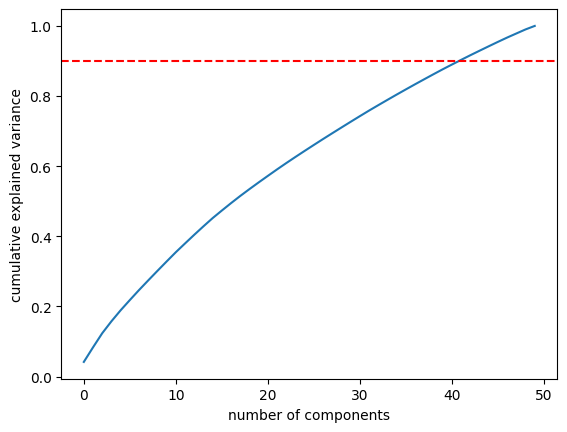

In [188]:
# reduce the dimension with PCA
# import TSNE
from sklearn.decomposition import PCA
pca = PCA().fit(df_most_common)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.axhline(y=.90, color = 'r', linestyle = '--') 
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [189]:
cumsum = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_))
best_component = cumsum[(cumsum >= .90) & (cumsum  < .95)].dropna().index[0] 
print(f'\n total most common words: {len(df_most_common.columns)}')

print('Best Component that keep 90% info:', best_component)
print(f'\n total most common words after reduction: {best_component}')


 total most common words: 50
Best Component that keep 90% info: 41

 total most common words after reduction: 41


In [257]:
cumsum[-15:]

,0
35,0.828907
36,0.843365
37,0.857489
38,0.871536
39,0.885209
40,0.898677
41,0.911646
42,0.924611
43,0.937099
44,0.949394


### use best component

In [190]:
pca = PCA(n_components=best_component).fit(df_most_common)
features = pd.DataFrame(pca.transform(df_most_common))
new_X = pd.concat([X, features, y], axis=1)
new_X.head()

,text,0,1,2,3,4,5,6,7,8,...,32,33,34,35,36,37,38,39,40,category
0,dessert recipe raisin lover hater steer clear ...,-0.125702,0.081043,0.062131,0.334775,0.544197,0.526319,-0.188715,-0.204926,-0.112670,...,-0.017727,-0.020807,-0.068766,0.030761,0.017468,-0.038050,-0.022064,-0.025734,0.008418,FOOD & DRINK
1,trump different response orlando vega massacre...,-0.160587,-0.228328,-0.482025,-0.334373,0.166725,0.347831,0.136245,0.036000,0.124554,...,-0.028971,0.023883,-0.007423,0.025421,-0.073423,-0.050055,-0.009547,0.016380,0.068323,GROUPS VOICES
2,friday talking point double standard hypocrisy...,-0.063585,-0.128449,-0.107732,0.028026,-0.040973,-0.040994,-0.032627,0.006688,-0.049561,...,-0.399846,0.621432,0.604908,0.093619,-0.398291,-0.269897,-0.193696,0.509126,0.532847,POLITICS
3,postthanksgiving detox diet overindulging than...,-0.013810,-0.128621,-0.158843,-0.035537,0.031125,-0.075326,-0.100469,0.031172,-0.091583,...,-0.006781,-0.010426,-0.043532,0.017928,0.003829,-0.009626,-0.010290,-0.011692,0.008081,FOOD & DRINK
4,6 quote encourage march march stress strain co...,-0.139693,-0.049855,0.047540,0.167952,-0.066238,-0.115108,-0.160567,-0.086081,-0.079983,...,0.016569,-0.048053,-0.049707,0.079955,-0.045972,-0.020455,-0.069389,-0.000888,0.040285,WELLNESS


In [191]:
#new_X.to_csv(f'news_10_category_sa_{SIZE_DATA}_PCA_data.csv', index=False)

In [215]:
new_X = df
train, test = train_test_split(new_X, test_size=0.2, random_state=42)
val, test = train_test_split(test, test_size=0.5, random_state=42)
print(f'Train set length: {len(train)} ; categories: {train["category"].nunique()}')
print(f'Val set length: {len(val)} ; categories: {val["category"].nunique()}')
print(f'Test set length: {len(test)} ; categories: {test["category"].nunique()}')

Train set length: 24000 ; categories: 10
Val set length: 3000 ; categories: 10
Test set length: 3000 ; categories: 10


In [216]:
def prepare_text_dict(all_words_freq):
    # the frequencies of words in text
    freq = all_words_freq
    clean_words = all_words_freq.index
        
    # vocabs set
    clean_words = set(clean_words)
    # convert words to indexes
    word2index = {w: i for i, w in enumerate(clean_words, 2)}  # start at 2
    word2index['<pad>'] = 1
    word2index['<unk>'] = 0

    # convert indexes to words
    index2word = {i: w for i, w in enumerate(clean_words, 2)}  # start at 2
    index2word[1] = '<pad>'
    index2word[0] = '<unk>'
    
    del freq, clean_words # just to save some RAM memory
    
    return word2index, index2word
# process text dict
text = pd.concat([train['text'], val['text']], axis=0)
word2index, index2word = prepare_text_dict(all_words_freq) # notice that we are won't use the 'test_set' vocabs

print('Total vocabs ', len(word2index))

Total vocabs  42189


In [217]:
# import labelencoder   
from sklearn.preprocessing import LabelEncoder
# instantiate labelencoder object
le = LabelEncoder()
# apply le on categorical feature columns
train['category'] = le.fit_transform(train['category'])
val['category'] = le.transform(val['category'])
test['category'] = le.transform(test['category'])

In [218]:
features_cols = new_X.columns.drop(['category', 'text', 'sa'])
#features_cols

In [219]:
label2encoding = dict(zip(le.classes_, le.transform(le.classes_)))
encoding2label = dict(zip(le.transform(le.classes_), le.classes_))

In [220]:
class Data(Dataset):
    def __init__(self, df, word2index):
        self.word2index = word2index # to index text

        # sort text by length of total words
        df['length'] = df['text'].apply(lambda x: len(x.split()))
        df.sort_values(by='length', inplace=True)

        # prepare data
        self.target = df['category'].values
        self.text = df['text'].apply(lambda x: x.split()).values
        self.features = df.loc[:, features_cols].values

    def __len__(self):
        return len(self.target)

    def __getitem__(self, item):
        sequence = [self.word2index[w] for w in self.text[item] if w in self.word2index]
        features = self.features[item]
        target = self.target[item]

        return {'target': target, 'features': features, 'sequence': sequence}


def Bert_data(df):
    # sort text by length of words
    df['length'] = df['text'].apply(lambda x: len(x.split()))
    df.sort_values(by='length', inplace=True)

     # prepare data
    
    target = df['category'].values
    text = df['text'] # the BertTokenizer will index them so we don't need for word2index
    features = df.loc[:, features_cols].values

    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    x_encoded = tokenizer.batch_encode_plus(text, pad_to_max_length=True)
    
    input_ids = torch.tensor(x_encoded['input_ids'],  device=device, dtype=torch.long)
    attention_mask = torch.tensor(x_encoded["attention_mask"],  device=device, dtype=torch.long) # to mark the text; if it was not a padding index,1 else 0
    #print(f'type of target: {type(target)}')
    target = torch.tensor(target,  device=device, dtype=torch.long)
    features = torch.tensor(features, device=device, dtype=torch.float)
    
    return TensorDataset(input_ids, attention_mask, features, target)

train_data = Data(train, word2index)
val_data = Data(val, word2index)
test_data = Data(test, word2index)

bert_train_data = Bert_data(train)
bert_val_data = Bert_data(val)
bert_test_data = Bert_data(test)

/Users/yaoyao/miniconda3/envs/tf/lib/python3.9/site-packages/transformers/tokenization_utils_base.py:2354: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [221]:
def pad_text(list_text, seq_length):
    paded_text = []
    for text in list_text:

        if len(text) == seq_length:
            paded_text.append(text)
        else:
            paded_text.append(text + (seq_length - len(text)) * [1]) # '1' is the index for 'PAD' in vocabs dict

    return paded_text


def collate_fn_padded(batch):
    target = [b['target'] for b in batch]
    features = [b['features'] for b in batch]
    sequence = [b['sequence'] for b in batch]
    # extract max_length
    max_length = max([len(b) for b in sequence])
    
    # pad text
    sequence = pad_text(sequence, max_length)

    target = torch.tensor(target, device=device, dtype=torch.long)
    features = torch.tensor(features, device=device, dtype=torch.float)
    sequence = torch.tensor(sequence, device=device, dtype=torch.long)
    # convert list to torch.tensor
    return {'target': target, 'features': features, 'sequence': sequence}

In [222]:
train_loader = DataLoader(train_data, batch_size=32, collate_fn=collate_fn_padded)
val_loader = DataLoader(val_data, batch_size=32, collate_fn=collate_fn_padded)
test_loader = DataLoader(test_data, batch_size=32, collate_fn=collate_fn_padded)

bert_train_loader = DataLoader(bert_train_data, batch_size=12)
bert_val_loader = DataLoader(bert_val_data, batch_size=12)
bert_test_loader = DataLoader(bert_test_data, batch_size=12)

In [223]:
all_words_freq

new            3241
photo          2914
one            2763
year           2339
time           2335
               ... 
macallan          1
makeoverand       1
ysls              1
khichdi           1
latif             1
Length: 42187, dtype: int64

In [224]:
vocab = word2index
word2vec_embeddings = {}
print('\nword2vec embeddings...')
# train a word2vec model on our text
all_words_lists = [[w for w in text.split()] for text in new_X['text'].values]
model = Word2Vec(sentences=all_words_lists, vector_size=VECTOR_SIZE, window=5, min_count=1, workers=4)
# save the model
model.save('word2vec.model')
# load the model
model = Word2Vec.load('word2vec.model')
# summarize vocabulary
words = list(model.wv.index_to_key)
for word in vocab.keys():
    if word in words:
        word2vec_embeddings[word] = model.wv[word]
    else:
        word2vec_embeddings[word] = np.zeros(VECTOR_SIZE)

missing = len(word2index) - len(word2vec_embeddings)
print(f'word2vec embeddings found for our vocabs: {len(word2vec_embeddings)} | missing: {missing} ; {missing / len(word2index) * 100:.1f}%')


word2vec embeddings...
word2vec embeddings found for our vocabs: 42189 | missing: 0 ; 0.0%


In [225]:

# create Look-Up table
def create_embedding_matrix(word_index, embedding_dict, dimension):
    embedding_matrix = np.zeros((len(vocab) + 1, dimension)) # (len_vocab, 100)

    for word, index in word_index.items():
        if word in embedding_dict.keys():
            embedding_matrix[index] = embedding_dict[word]

    return embedding_matrix

embedding_matrix = create_embedding_matrix(vocab, word2vec_embeddings, VECTOR_SIZE)

In [226]:
class LSTM_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_layers, output_size, p=.5, use_features=False,
                 features_size=None):

        super().__init__()  # This is needed to initialize the nn.Module properly

        # 'use_features' if used, we supposed to give text and feature data to the model to make prediction.
        # create 'use_features' as 'self.use_features' so we can use it in the hole class functions(e.g. 'forward') instead of just in '__init__' attrbute
        self.use_features = use_features

        # 'Embedding' layer works like a lookup table(dictionary). The words are the keys in this table, while the dense word vectors are the values.
        self.Embedding = nn.Embedding(vocab_size, embedding_dim)

        # LSTM is the Long Short-Term Memory layer that will take the vectors represntations and extract the semantics/hidden_states
        self.LSTM = nn.LSTM(embedding_dim, hidden_size, num_layers=n_layers, bidirectional=False, batch_first=True, dropout=p)
        # if 'batch_first=True' 'hidden' shape will be (num_layers * num_directions, batch, hidden_size)
        # if 'batch_first=False' 'hidden' shape will be (num_layers * num_directions, seq_len, hidden_size)
        

        # A Dense/Linear layer that learn from last_hidden_state (optional layer; you can remove it)
        self.Linear = nn.Linear(hidden_size, hidden_size)

        # Dropout layer that help regularizing and prevent overfitting (optional layer)
        # It randomly zeroes some of the elements of the input tensor with probability 'p'
        self.Dropout = nn.Dropout(p)

        # Dense/Linear layer to predict the class of the text/sequence
        self.output = nn.Linear(hidden_size, output_size)

        # add these layers if 'use_features'
        if self.use_features:
            # this dense layer will take the features and tune its parameters
            self.f_Linear = nn.Linear(features_size, hidden_size)

            # this dense layer will take the output from 'f_Linear' and predict the class of the text/sequence
            self.f_output = nn.Linear(hidden_size, output_size)

    def forward(self, x, features=None):  # run the network

        Embedding = self.Embedding(x)  # map the words to their vectors representations by the Embedding layer

        output, (hidden, cell) = self.LSTM(Embedding)  # calculate the sequence/text sementics
        # 'output' comprises all the hidden states in the last layer
        # (hidden, cell) comprises the hidden states after the last timestep

        # 'cell' state contains info about wether to keep a hidden state or no (num_layers * num_directions, batch, hidden_size)
        # 'output' state is a tensor of all the 'hidden' states from each time step  (seq_len, batch, num_directions * hidden_size)
        # 'hidden' state is the hidden states from the last time step  (num_layers * num_directions, batch, hidden_size) 

        last_hidden_state = hidden[-1, :, :]  # last hidden state from the last time step (seq_len, hidden_size)

        x = nn.functional.leaky_relu(self.Linear(last_hidden_state), .001)
        # 'leaky_relu' is similar to relu activation function, it just let the values to be between '0.001' and any other number

        x = self.Dropout(x)  # apply dropout

        # combine the outputs of text and features if 'use_features' is 'True'.
        # we will multiply each output by 0.5 to get half the original weights, and then combine the two halves
        # to have a predictions from both outputs weights.
        if self.use_features:

            x = self.output(x) * 0.5  # half the weights

            x_2 = nn.functional.leaky_relu(self.f_Linear(features), .001)
            x_2 = self.f_output(x_2) * 0.5  # half the weights

            final_x = x + x_2  # combine the two halves outputs

            return final_x

        else:
            return self.output(x)  # if 'use_features' is 'False' then 'features' output won't be calculated


In [227]:
class CNN_Model(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_size, n_filters, filter_sizes, output_size, p=.5, use_features=False,
                 features_size=None):
        super().__init__()
        self.use_features = use_features
        self.Embedding = nn.Embedding(vocab_size, embedding_dim)

        # we will build 'Conv2d' layers as much as the amount of 'filter_sizes' list
        # the 'kernel_size' will be (filter_size, embedding_dim),
        # 'filter_size' is the number words to take as 'n-gram'
        # 'embedding_dim' is the vector representation for the word (Embedding dimentions)
        # 'ModuleList' helps in creating more then one layer at once
        print(filter_sizes)
        self.convs = nn.ModuleList(nn.Conv2d(1, n_filters, (ks, embedding_dim)) for ks in filter_sizes)  # 'convs' will be as much as 'filter_sizes' list

        # note: There is no hidden layer between 'convs' layers and 'output' layer


        # we will concatenate all 'convs' layers outputs and feed them to the 'output' layer
        self.output = nn.Linear(len(filter_sizes) * n_filters, output_size)

        self.Dropout = nn.Dropout(p)

        if self.use_features:
            self.f_Linear = nn.Linear(features_size, hidden_size)
            self.f_output = nn.Linear(hidden_size, output_size)

    def forward(self, x, features=None):
        # the 'Conv2d layer' wants inputs of shape (batch, Channel, Height, Width)
        # our text is of shape(batch, seq_lens)

        # after feeding text to the 'Embedding' layer, we will have shape(batch, seq_lens, embedding_dim)
        Embedding = self.Embedding(x)

        # the convolutional layer wants the inputs to be of
        # shape(batch,  Channel, Height, Width) and the 'Embedding' layer's output is shape(batch, seq_lens, embedding_dim)
        # to make 'Embedding' output correct to feed a 'convs' layer, its shape must be same as the shape of a conv layer.

        # the batch in conv shape exist in 'Embedding' shape.
        # the Channel in conv shape will be the number of embedding layers; in our case it's 1 'Embedding' layer.
        # the Height in conv shape  will be the 'seq_lens'(num words or n-gram)
        # the Width in conv shape  will be the 'embedding_dim'(vector representation of a word)

        # conv(batch, Channel, Height, Width) = Embedding(batch, num_embeddings, seq_lens, embedding_dim)
        Embedding = Embedding.unsqueeze(1) # create Channel dimension

        convs = [F.relu(c(Embedding)).squeeze(3) for c in self.convs]
        # after applying a conv layer, the output will be of shape (batch, Height, Width, Channel)
        # the 'max_pool1d' layer doesn't want the channel dimension(third dim), so we will remove/squeeze it by using .squeeze(3)

        convs = [F.max_pool1d(c, c.shape[2]).squeeze(2) for c in convs]
        # the kernel_size is the word embedding_dim (c.shape[2]; which is the Width dimension(second dim) ).
        # since the Width dimension (c.shape[2]) is pooled, the second dimension is empty.
        # so we will remove/squeeze it by using .squeeze(2)

        # we will concatenate all 'convs' outputs (note that 'convs' is a list of all 'convs' layers
        # outputs; e.g. [conv1, conv2, ...])

        # the shape is, 'batch_size' and the sum of all the filters of all 'convs'
        # layers (e.g. n_filter1 + n_filter2 ..., depending on how many conv layer there)
        total_pools = torch.cat(convs, dim=1)  # (batch, total_filters)

        x = self.Dropout(total_pools)

        if self.use_features:
            x = self.output(x) * 0.5
            x_2 = nn.functional.leaky_relu(self.f_Linear(features), .001)
            x_2 = self.f_output(x_2) * 0.5
            final_x = x + x_2
            return final_x
        else:
            return self.output(x)


# We have to build a function that pad tha sequences that are less then the filter size
# The model will throw an error if a sentence/sequence is less then the kernel_size of certain conv, so we must pad it
# to the maximum size of kernel_size.
def cnn_padding_to_match_filtersize(text, filter_sizes):
    features_ = []
    for f in text:
        f = f.cpu().numpy().tolist()
        if len(f) < max(filter_sizes):
            f += [1] * (max(filter_sizes) - len(f))
            features_.append(f)
        else:
            features_.append(f)

    return torch.LongTensor(features_).to(device)


In [228]:
def train_func(model, optimizer, criterion, iterator, using_features=False):
    # create lists to append the scores of each metric from every batch, so we can take the mean/average of each metric as the final scores
    accuracy_list = []
    f1_list = []
    loss_list = []
    
    model.train() # train mode (has specific impact on some layers,e.g. Dropout layer)
    
    for batch in iterator: # loop over the whole data batch-by-batch
        optimizer.zero_grad()
        text = batch['sequence']
        features = batch['features']
        label = batch['target']
        if type(model).__name__ == 'CNN_Model':  # for CNN training
            # CNN is using filter_sizes(e.g. 3, 4, 5), every conv layer has sepcific kernel size
            # a conv layer kernel size is (kernel_size, embedding_dim), so we must pad short texts to the maximum size of filter_sizes list
            # we will do this using the function we created before (in CNN archeticture).

            filter_sizes = [2, 3, 5, 7]
            if using_features:
                output = model(cnn_padding_to_match_filtersize(text, filter_sizes), features)
            else:
                output = model(cnn_padding_to_match_filtersize(text, filter_sizes))

        else:  # for other models
            if using_features:
                output = model(text, features)
            else:
                output = model(text)
                
        loss = criterion(output, label) # calcualte loss function
        loss.backward() # backprobgate loss function

        # Gradient clipping is a technique that tackles exploding gradients. 
        # The idea of gradient clipping is very simple: If the gradient gets too large, we rescale it to keep it small.
        nn.utils.clip_grad_norm_(model.parameters(), 1) # optinal 
        
        # calculate optimizer
        optimizer.step()

        # take the index class for the maximum prediction probability (e.g. [.2, .3, .5], output.argmax(1) will be index 2 is max arg)
        output = output.argmax(1) # 1 will be the 1-axis/dim
        
        # detach: to exclude elements of computation from gradient calculation(backward)
        # cpu: convert the data from GPU cache to CPU cache
        # detach: convert data from torch tensor to np array so we can use any metric(it's build with numpy API so it doesn't except torch API) 
        output = output.detach().cpu().numpy() 
        label = label.detach().cpu().numpy()

        # append metrices values 
        loss_list.append(loss.detach().cpu().numpy().item()) # item will give you just the loss value
        accuracy_list.append(accuracy_score(label, output)) # calculate accuracy_score
        f1_list.append(f1_score(label, output, average='macro')) # calculate f1_score

    # calculate the mean value of the whole epoch
    loss = np.mean(loss_list).round(4) # round(4) will give us the last 4 numbers after '.' (e.g. 2.9567)
    f1 = np.round(np.mean(f1_list) * 100, 1) # multiply the value with 100 so it will look like percentage (e.g. 0.99 * 100 = 99)
    accuracy = np.round(np.mean(accuracy_list) * 100, 1)  # multiply the value with 100 so it will look like percentage (e.g. 0.99 * 100 = 99)

    return loss, f1, accuracy

In [229]:
def eval_func(model, criterion, iterator, using_features=False):
    # create lists to append the scores of each metric from every batch, so we can take the mean/average of each metric as the final scores
    accuracy_list = []
    f1_list = []
    loss_list = []

    model.eval() # train mode (has specific impact on some layers,e.g. Dropout layer)
    
    for batch in iterator:# loop over the whole data batch-by-batch
        # PREPARE DATA
        text = batch['sequence']
        features = batch['features']
        label = batch['target']
            
        # FEED MODEL
        
        with torch.no_grad(): # don't  calculate  gradients
            if type(model).__name__ == 'CNN_Model':  # for CNN model
                # CNN is using filter_sizes(e.g. 3, 4, 5), every conv layer has sepcific kernel size
                # conv layer kernel size is of shape(kernel_size, embedding_dim), so we must pad short texts to the maximum size filter_sizes
                # we will do this using the function we created before (in CNN archeticture).
                filter_sizes = [2, 3, 5, 7]
                if using_features: 
                    output = model(cnn_padding_to_match_filtersize(text, filter_sizes), features)
                else:
                    output = model(cnn_padding_to_match_filtersize(text, filter_sizes))

            else:  # for other models
                if using_features:
                    output = model(text, features)
                else:
                    output = model(text)

            loss = criterion(output, label) # calcualte loss function

        # take the index class for the maximum prediction probability (e.g. [.2, .3, .5], output.argmax(1) will be index 2 is max arg)
        output = output.argmax(1) # 1 will be the 1-axis/dim
        
        # detach: to exclude elements of computation from gradient calculation(backward)
        # cpu: convert the data from GPU cache to CPU cache
        # detach: convert data from torch tensor to np array so we can use any metric(it's build with numpy API so it doesn't except torch API) 
        output = output.detach().cpu().numpy() 
        label = label.detach().cpu().numpy()

        # append metrices values 
        loss_list.append(loss.detach().cpu().numpy().item()) # item will give you just the loss value
        accuracy_list.append(accuracy_score(label, output)) # calculate accuracy_score
        f1_list.append(f1_score(label, output, average='macro')) # calculate f1_score

    # calculate the mean value of the whole epoch
    loss = np.mean(loss_list).round(4) # round(4) will give us the last 4 numbers after '.' (e.g. 2.9567)
    f1 = np.round(np.mean(f1_list) * 100, 1) # multiply the value with 100 so it will look like percentage (e.g. 0.99 * 100 = 99)
    accuracy = np.round(np.mean(accuracy_list) * 100, 1)  # multiply the value with 100 so it will look like percentage (e.g. 0.99 * 100 = 99)

    return loss, f1, accuracy

In [230]:
# --- pred loop --- #
def pred(model, iterator, loss_function, using_features=False):
    # create lists to append the scores of each metric from every batch, so we can take the mean/average of each metric as the final scores
    accuracy_list = []
    f1_list = []
    loss_list = []

    model.eval() # train mode (has specific impact on some layers,e.g. Dropout layer)
    
    for batch in iterator:# loop over the whole data batch-by-batch
        # PREPARE DATA 
        # extract non-BERT data if the current model is not BERT
        text = batch['sequence']
        features = batch['features']
        label = batch['target']

        # FEED DATA
        with torch.no_grad(): # don't calculate gradients
            if type(model).__name__ == 'CNN_Model':  # for CNN model
                # CNN is using filter_sizes(e.g. 3, 4, 5), every conv layer has sepcific kernel size
                # conv layer kernel size is of shape(kernel_size, embedding_dim), so we must pad short texts to the maximum size filter_sizes
                # we will do this using the function we created before (in CNN archeticture).
                
                filter_sizes = [2, 3, 5, 7]
                if using_features:
                    output = model(cnn_padding_to_match_filtersize(text, filter_sizes), features)
                else:
                    output = model(cnn_padding_to_match_filtersize(text, filter_sizes))

            else:  # for other models
                if using_features:
                    output = model(text, features)
                else:
                    output = model(text)

            loss = loss_function(output, label) # calcualte loss function
        
        # take the index class for the maximum prediction probability (e.g. [.2, .3, .5], output.argmax(1) will be index 2 is max arg)
        output = output.argmax(1) # 1 will be the 1-axis/dim
        
        # detach: to exclude elements of computation from gradient calculation(backward)
        # cpu: convert the data from GPU cache to CPU cache
        # detach: convert data from torch tensor to np array so we can use any metric(it's build with numpy API so it doesn't except torch API) 
        output = output.detach().cpu().numpy() 
        label = label.detach().cpu().numpy()

        # append metrices values 
        loss_list.append(loss.detach().cpu().numpy().item()) # item will give you just the loss value
        accuracy_list.append(accuracy_score(label, output)) # calculate accuracy_score
        f1_list.append(f1_score(label, output, average='macro')) # calculate f1_score

    # calculate the mean value of the whole epoch
    loss = np.mean(loss_list).round(4) # round(4) will give us the last 4 numbers after '.' (e.g. 2.9567)
    f1 = np.round(np.mean(f1_list) * 100, 1) # multiply the value with 100 so it will look like percentage (e.g. 0.99 * 100 = 99)
    accuracy = np.round(np.mean(accuracy_list) * 100, 1)  # multiply the value with 100 so it will look like percentage (e.g. 0.99 * 100 = 99)
    name = type(model).__name__ # the name of the Model

    return loss, f1, accuracy, name

In [231]:
def training_model(model, optimizer, criterion, train_iterator, eval_iterator, epochs=1000, using_features=False):
    print('\nTraining Started...\n')
    # for early stopping
    stop = 0  # increase this number if the model didn't become more accurate compared to the last best epoch
    min_eval_acc = 0. # assign this number as the best evaluation accuracy score

    for epoch in range(epochs): # Epochs Loop 
    
        loss, f1, acc = train_func(model, optimizer, criterion, train_iterator, using_features)  # train model
        eval_loss, eval_f1, eval_acc = eval_func(model, criterion, eval_iterator, using_features)  # evaluate model


        # save current-epoch model file, so we can coninue training later (fine-tuning the paremeters of last epoch). and delete
        # the previous current-epoch model file, to avoid making lots of files(you can delete this section if you want)
        # best model scores
        if eval_acc > min_eval_acc: # current accuracy greater then the best accuracy 
            min_eval_acc = eval_acc # assign 'min_eval_acc' as the best accuracy
            #training scores
            best_loss = loss
            best_acc = acc
            best_f1 = f1
            
            #evaluation scores
            best_eval_loss = eval_loss
            best_eval_acc = eval_acc
            best_eval_f1 = eval_f1

            best_model = model.state_dict() # best model parameters
            best_epoch = epoch + 1  # '+ 1' because 'epoch' starts from 0
            stop = 0 # reset 'stop' counter
            # print the current as the 'Best Epoch score'
            print(
                f'BEST Epoch({best_epoch} | Train(loss: {best_loss} | acc: {best_acc} | f1-score: {best_f1}) & Eval(loss: {best_eval_loss} | acc: {best_eval_acc} | f1-score: {best_eval_f1})\n')
            return best_model, best_epoch, best_loss, best_acc, best_f1, best_eval_loss, best_eval_acc, best_eval_f1

        # if current accuracy wasn't greater then the best accuracy add 1 to 'stop'
        else:
            stop += 1
            # print the current epoch as the 'Normal Epoch score'
            print(
                f'Epoch({epoch + 1} | Train(loss: {loss} | acc: {acc} | f1-score: {f1}) & Eval(loss: {eval_loss} | acc: {eval_acc} | f1-score: {eval_f1})\n')
        
        # if 'stop' reached 5 it will stop training
        if stop == 5:
            print('EARLY STOPPING!')
            # print the best epoch recorded during the whole training
            print(
                f'BEST EPOCH({best_epoch} | Train(loss:{best_loss} | acc:{best_acc} | f1-score:{best_f1}) & Eval(loss: {best_eval_loss} | acc: {best_eval_acc} | f1-score: {best_eval_f1})\n')
            return best_model, best_epoch, best_loss, best_acc, best_f1, best_eval_loss, best_eval_acc, best_eval_f1
            # save best model
            # torch.save(best_model, f'epoch_{best_epoch}_val_loss_{best_eval_loss}_val_acc_{best_eval_acc}_val_f1_{best_eval_f1}.pt')
            break

In [232]:
vocab_size = len(word2index)
embedding_dim = 50
output_size = len(le.classes_)

hidden_size = 64
n_filters = 64
n_layers = 2
filter_sizes = [2, 3, 5, 7]
print('Size Of Vocab: ', vocab_size)


model_lstm = LSTM_Model(vocab_size, embedding_dim, hidden_size, n_layers, output_size)

model_cnn = CNN_Model(vocab_size, embedding_dim, hidden_size, n_filters, filter_sizes, output_size)
models = [model_cnn, model_lstm]



Size Of Vocab:  42189
[2, 3, 5, 7]


In [233]:
loss_function = nn.CrossEntropyLoss().to(device)
def count_parameters(model):
    # to know how many parametres a 'trained' model has  
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
for clf in models:
    print('----------------------')
    print('----------------------')
    print('model Name: ', type(clf).__name__) # print Model Name
    print(f'{type(clf).__name__} has {count_parameters(clf):,} trainable parameters') # print Model Total Parameters 
    clf = clf.to(device) # convert model to GPU memory for fast training
    # use flexible learning rate
    
    optimizer = AdamW(clf.parameters(), lr= 0.01, weight_decay=0.01) # assign AdamW as optimizer
    
    training_model(clf, optimizer, loss_function, train_loader, val_loader, epochs=100, using_features=False)

----------------------
----------------------
model Name:  CNN_Model
CNN_Model has 2,166,676 trainable parameters

Training Started...



BEST Epoch(1 | Train(loss: 2.3584 | acc: 36.5 | f1-score: 27.9) & Eval(loss: 1.5085 | acc: 53.5 | f1-score: 45.3)

----------------------
----------------------
model Name:  LSTM_Model
LSTM_Model has 2,177,236 trainable parameters

Training Started...

BEST Epoch(1 | Train(loss: 1.9058 | acc: 33.3 | f1-score: 21.1) & Eval(loss: 1.6512 | acc: 43.5 | f1-score: 32.2)



#### result
2k - Top_50_VecSize50, learning_rate-0.01, 
LSTM, 17.3
CNN, 42.4

6k - Top_50_VecSize50, learning_rate-0.01, 
LSTM, 29.5
CNN, 45.5

10k - Top_50_VecSize50, learning_rate-0.01, 
LSTM, 57.1
CNN, 59.6

30k - Top_50_VecSize50, learning_rate-0.01, 
LSTM, 66.9
CNN, 62.7

In [226]:
vectorizer = TfidfVectorizer()
# transform the text into a vector
X_vec = vectorizer.fit_transform(X)

In [230]:
# standardize the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
X_vec_std = scaler.fit_transform(X_vec)

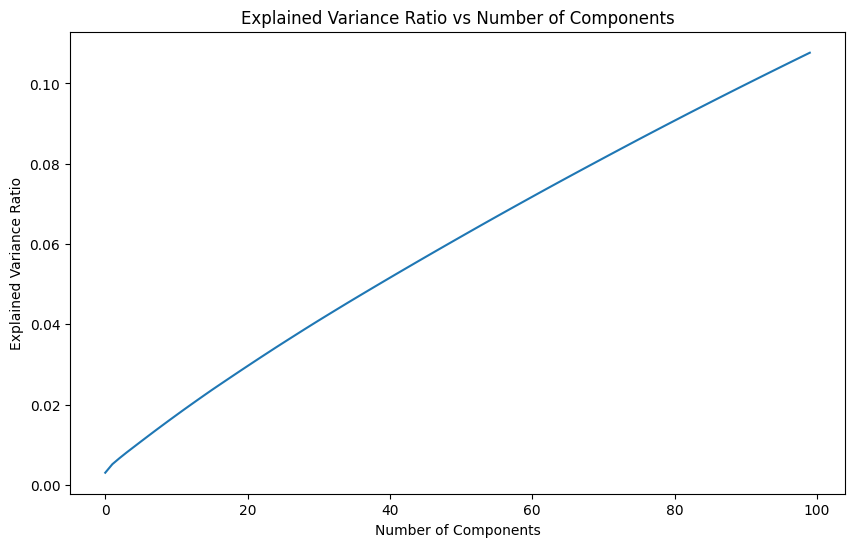

In [236]:
# plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs Number of Components')
plt.show()

cumulative explained variance values: 
           0
0   0.003014
1   0.005143
2   0.006641
3   0.008057
4   0.009416
..       ...
95  0.104143
96  0.105015
97  0.105887
98  0.106757
99  0.107625

[100 rows x 1 columns]


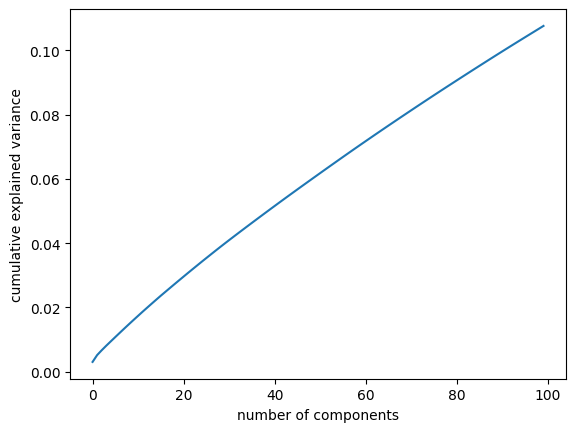

In [235]:
# plot PCA explained_variance_ratio_
plt.plot(np.cumsum(pca.explained_variance_ratio_))
#plt.axhline(y=.90, color = 'r', linestyle = '--') 
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

# create dataframe of explained_variance_ratio_ values
cumsum = pd.DataFrame(np.cumsum(pca.explained_variance_ratio_))
print('cumulative explained variance values: ')
print(cumsum)